`example_scripts/fritts/run076/r76_analysis_2sided.c`

In [1]:
#Imports
import sys, sre_yield, math
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../python')
import R76Tools as R76

#Variables
s: int=0
datapath: str="/data/chocula/fritts/data/k100proc/midasrq/byseries/"
sers: list=["07220330_1639", "07220405_1646", "07220406_1720"]
serlabel: list=["no_source","22Na_48cm","22Na_40cm","muons","muons_NaI-triggered"]
chans: list=[x for x in sre_yield.AllStrings(r'[A-F]')]
ser = sers[s]

In [2]:
#Load Data
e,z = R76.makechain_list(ser,path=datapath
                         #,filters=['PTOFamps','PFS1OFamps','PES1OFamps','EventCategory']
                        )
z = z[0]

In [3]:
#Aliases
z['c14_0'] = (z['PFS1OFamps']/z['PTOFamps'] > 0.25) & (z['PTOFamps'] > 0.48e-6) & (z['PTOFamps'] < 0.53e-6)
z['c14_1'] = (z['PFS1OFamps']/z['PTOFamps'] > 0.15) & (z['PTOFamps'] > 0.37e-6) & (z['PTOFamps'] < 0.47e-6)
z['c14_2'] = (z['PES1OFamps']/z['PTOFamps'] > 0.25) & (z['PTOFamps'] > 0.45e-6) & (z['PTOFamps'] < 0.52e-6)

z['cbacks_0'] = (z['PTOFamps'] > 2.3e-6)  & (z['PTOFamps'] < 3e-6) #IF YOU DO NOT ADD () TO ALL
z['cbacks_1'] = (z['PTOFamps'] > 1.91e-6) & (z['PTOFamps'] < 2.5e-6) #THEN IT CHANGES EVERYTHING
z['cbacks_2'] = (z['PTOFamps'] > 2.21e-6) & (z['PTOFamps'] < 2.88e-6) #DON'T FORGET!

#Aliases to correct for time shifts in some channels
for c in chans: #Set a default for the ones we're not changing
    for d in ['1','2']:
        z['P'+c+'S'+d+'r20'] = z['P'+c+'S'+d+'WKr20']
#THIS IS COMPLETE ONLY FOR s == 2
if s == 0:
    z['PBS1r20'] = z['PBS1WKr20'] - (z.index > 220e3)*5e-6
    z['PCS1r20'] = z['PCS2WKr20'] - (z.index > 60e3)*5e-6
    z['PFS2r20'] = z['PFS2WKr20'] - (z.index > 160e3)*5e-6
if s == 1:
    z['PCS1r20'] = z['PCS1WKr20'] - (z.index > 120e3)*5.5e-6
    z['PFS2r20'] = z['PFS2WKr20'] - (z.index > 105e3)*5.5e-6
    z['PCS2r20'] = z['PCS2WKr20'] - (z.index > 55e3)*5e-6
if s == 2:
    z['PCS2r20'] = z['PCS2WKr20'] - (z.index > 90e3)*5.5e-6

#Good time info cut removes some of the events for which the walk algorithm fails
z['ctgood'] = (
    (  z['PFS1WKr20'] > 0.00036) & (z['PFS1WKr20'] < 0.00043) 
    & (z['PES1WKr20'] > 0.00036) & (z['PES1WKr20'] < 0.00043)
    & (z['PDS1WKr20'] > 0.00036) & (z['PDS1WKr20'] < 0.00043) 
    & (z['PCS1WKr20'] > 0.00036) & (z['PCS1WKr20'] < 0.00043)
)

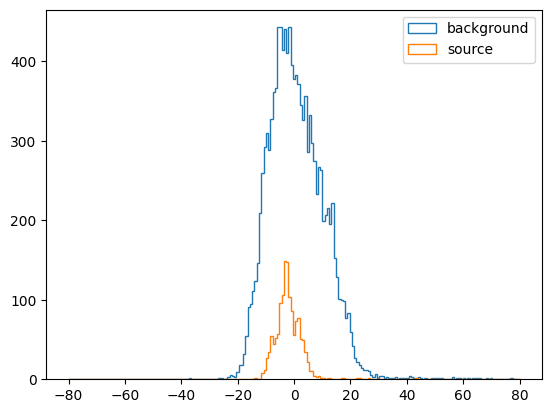

In [8]:
zcut = z[(z['EventCategory'] != 1) & z['ctgood']]
zback = zcut[zcut['cbacks_'+str(s)]]
z14 = zcut[zcut['c14_'+str(s)]]

c1 = 'C'; c2 = 'E'
s1 = '1'; s2 = '1'
a1 = 'P'+c1+'S'+s1+'r20'; a2 = 'P'+c2+'S'+s2+'r20'
plt.hist((zback[a1] - zback[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='background')
plt.hist((z14[a1] - z14[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='source')

plt.legend()
plt.show()

In [9]:
#Checking the output of cuts

print('z:\t',len(z)) #Good
print('!crand:\t',len(z[(z['EventCategory'] != 1)])) #Good
print('F>:\t',len(z[z['PFS1WKr20']>0.00036])) #Good
print('F<:\t',len(z[z['PFS1WKr20']<0.00043])) #Good
print('F:\t',len(z[(z['PFS1WKr20']>0.00036) & (z['PFS1WKr20']<0.00043)])) #Good
print('ctgood (man):\t',len(z[(  z['PFS1WKr20'] > 0.00036) & (z['PFS1WKr20'] < 0.00043) 
    & (z['PES1WKr20'] > 0.00036) & (z['PES1WKr20'] < 0.00043) 
    & (z['PDS1WKr20'] > 0.00036) & (z['PDS1WKr20'] < 0.00043) 
    & (z['PCS1WKr20'] > 0.00036) & (z['PCS1WKr20'] < 0.00043)]))
print('ctgood:\t',len(z[z['ctgood']])) #Good
print('cut:\t',len(zcut)) #Good
print('backs:\t',len(zback)) #Good
print('14s:\t',len(z14)) #Good

z:	 230759
!crand:	 229759
F>:	 229435
F<:	 211695
F:	 210371
ctgood (man):	 191694
ctgood:	 191694
cut:	 191694
backs:	 12419
14s:	 1396


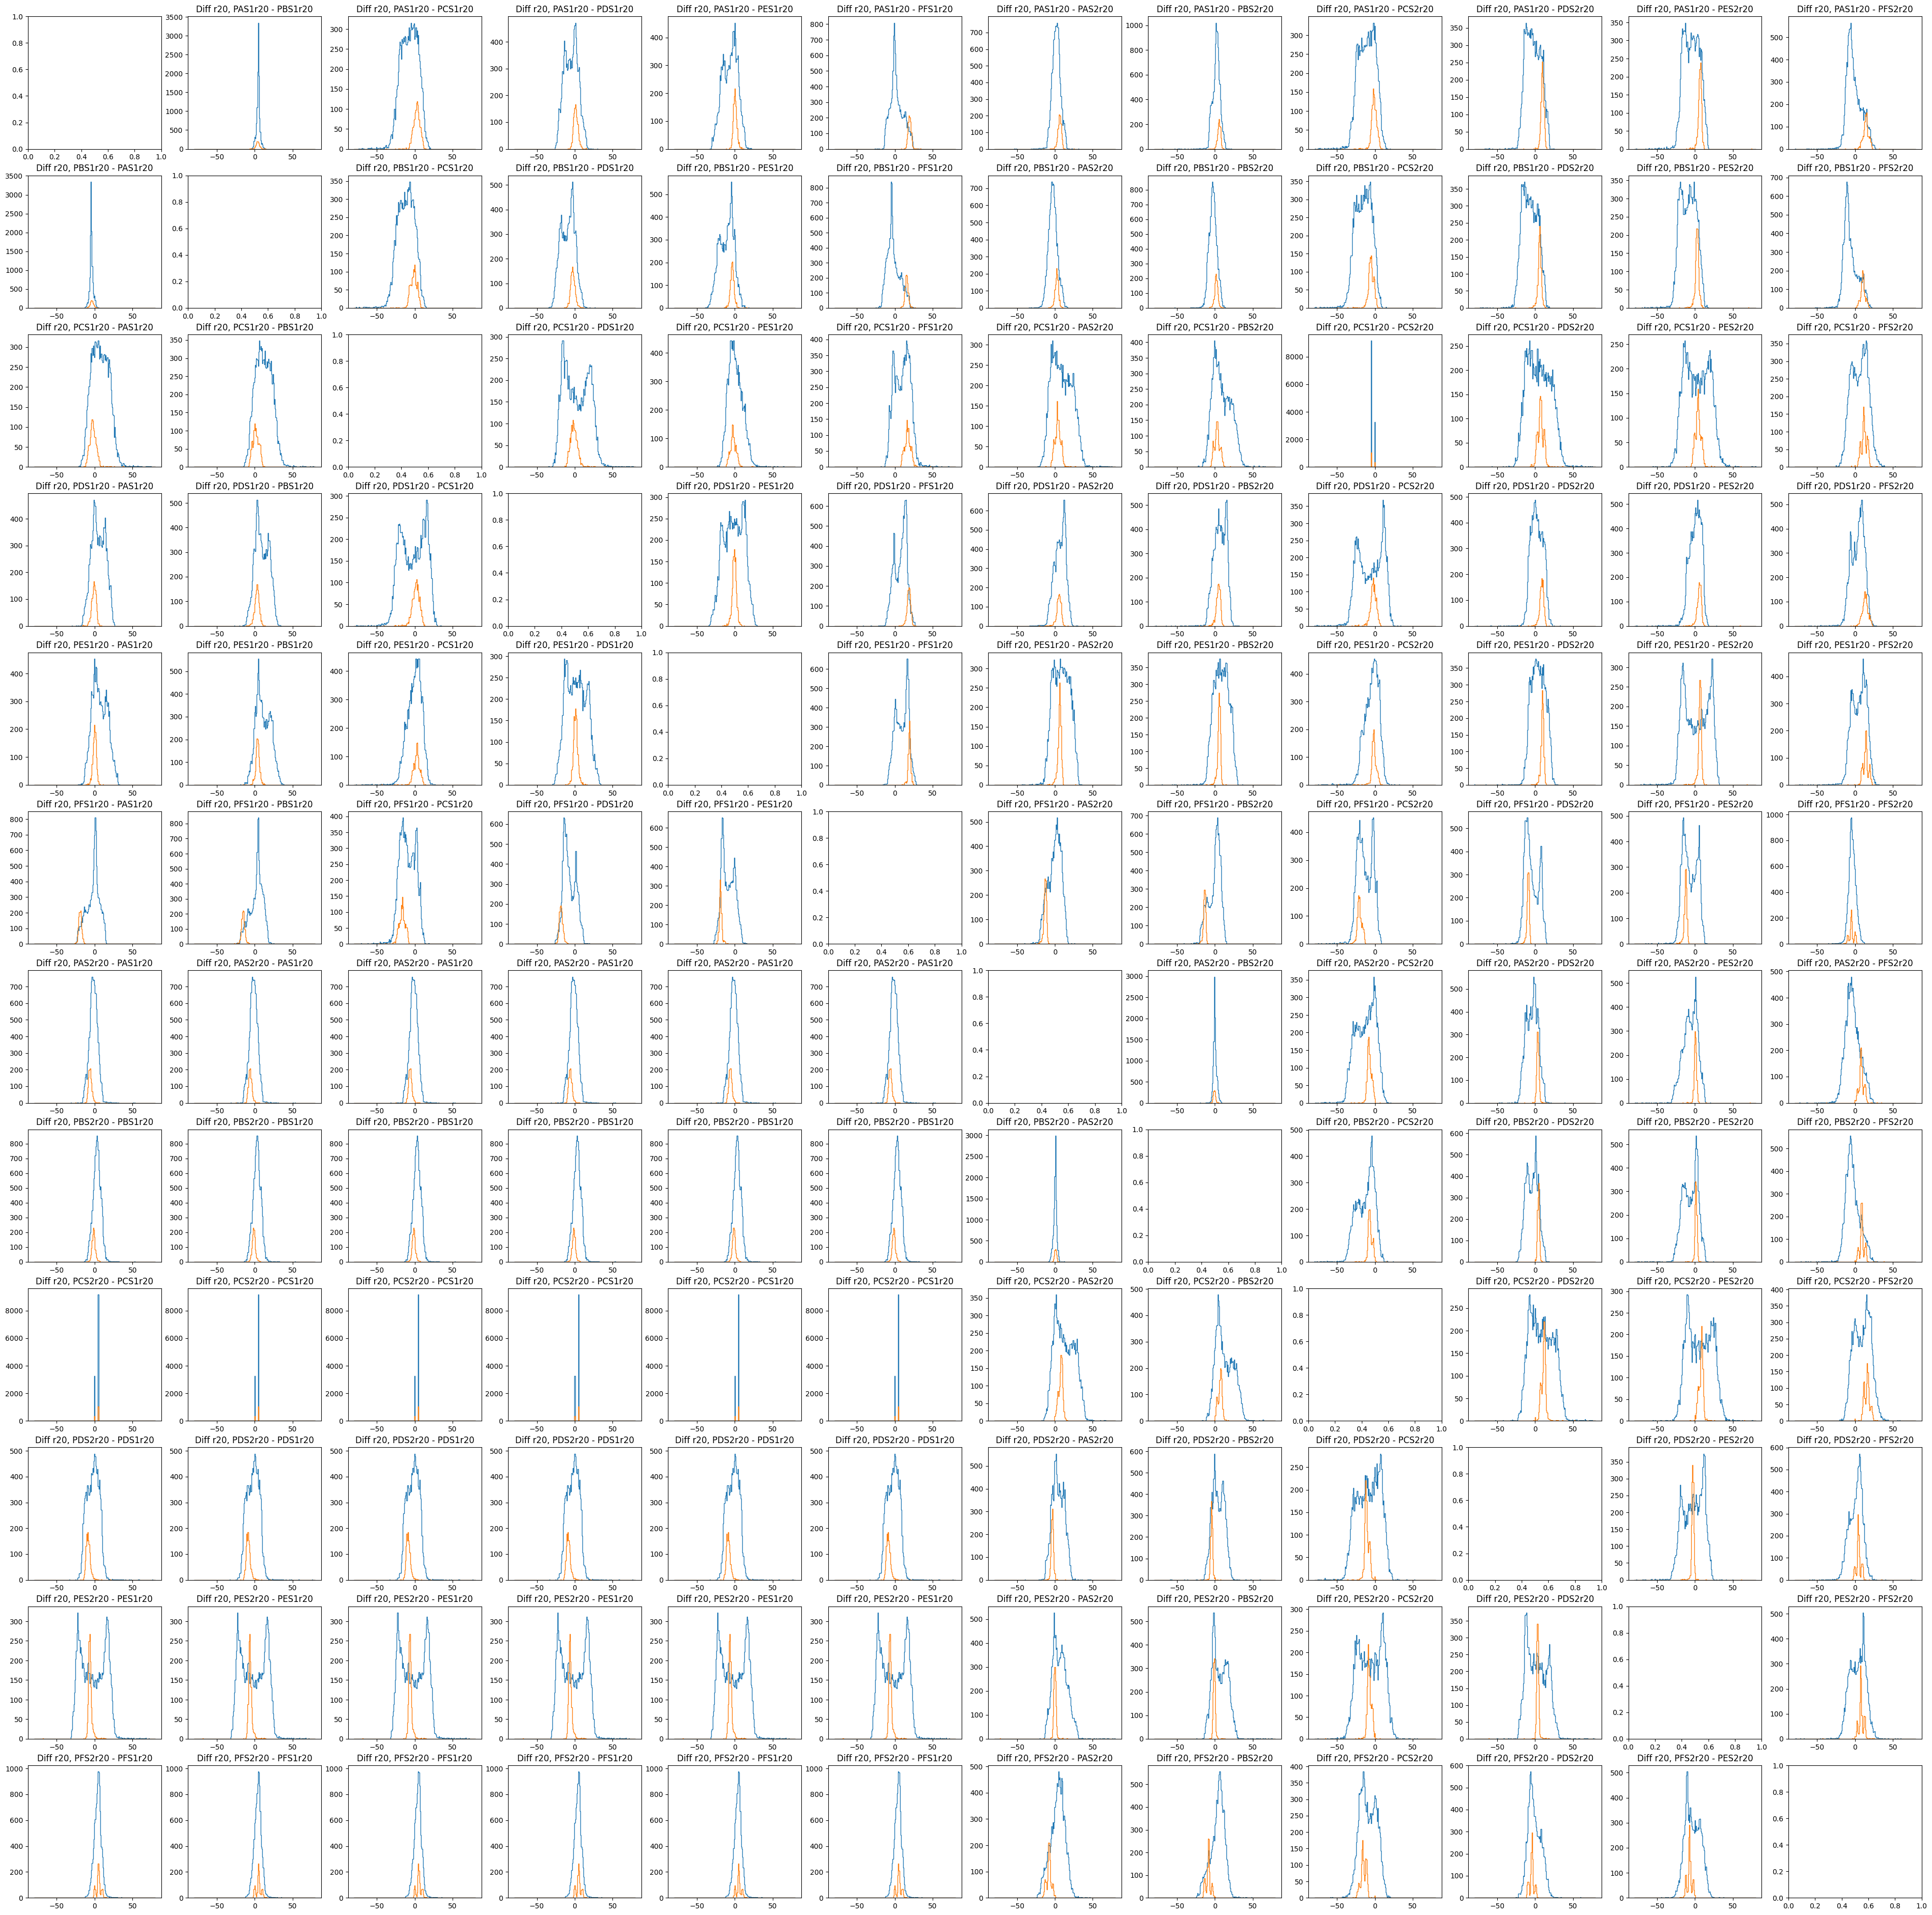

In [6]:
scale = 4
_,ax = plt.subplots(len(chans)*2,len(chans)*2,figsize=(scale*2*len(chans),scale*2*len(chans)))
for i,c1 in enumerate(chans):
    for j,c2 in enumerate(chans):
        a1 = 'P'+c1+'S1r20'; a2 = 'P'+c2+'S1r20'
        if a1 != a2:
            ax[i,j].set_title('Diff r20, '+a1+' - '+a2)
            ax[i,j].hist((zback[a1] - zback[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='background')
            ax[i,j].hist((z14[a1] - z14[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='source')
        
        a1 = 'P'+c1+'S1r20'; a2 = 'P'+c2+'S2r20'
        ax[i,j+len(chans)].set_title('Diff r20, '+a1+' - '+a2)
        ax[i,j+len(chans)].hist((zback[a1] - zback[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='background')
        ax[i,j+len(chans)].hist((z14[a1] - z14[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='source')

        a1 = 'P'+c1+'S2r20'; a2 = 'P'+c1+'S1r20'
        ax[i+len(chans),j].set_title('Diff r20, '+a1+' - '+a2)
        ax[i+len(chans),j].hist((zback[a1] - zback[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='background')
        ax[i+len(chans),j].hist((z14[a1] - z14[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='source')

        a1 = 'P'+c1+'S2r20'; a2 = 'P'+c2+'S2r20'
        if a1 != a2:
            ax[i+len(chans),j+len(chans)].set_title('Diff r20, '+a1+' - '+a2)
            ax[i+len(chans),j+len(chans)].hist((zback[a1] - zback[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='background')
            ax[i+len(chans),j+len(chans)].hist((z14[a1] - z14[a2])*1e6,bins=np.linspace(-80,80,200),histtype='step',label='source')
plt.show()

mismatches for s=0:
- S1pC - S1pE
- S1pD - S1pE
- S2pC - S2pD
- S2pC - S2pF
- S2pD - S2pF
- S2pE - S2pF